### Torch.nn 이 실제로 무엇인가?
* PyTorch 는 여러분이 신경망(neural network)을 생성하고 학습시키는 것을 도와주기 위해서 torch.nn, torch.optim, Dataset, 그리고 DataLoader 와 같은 잘 디자인된 모듈과 클래스들을 제공함.
* 이들의 성능을 최대한 활용하고 여러분의 문제에 맞게 커스터마이즈하기 위해서, 정확히 이들이 어떤 작업을 수행하는지 이해할 필요가 있음.
* 이해를 증진시키기 위해서, 우리는 먼저 이들 모델들로부터 아무 피쳐도 사용하지 않고 MNIST 데이터셋에 대해 기초적인 신경망을 학습시킬 것.
* 우리는 처음에는 가장 기초적인 PyTorch 텐서(tensor) 기능만을 사용할 것.
* 그리고나서 우리는 점차적으로 torch.nn, torch.optim, 또는 DataLoader 로부터 한번에 하나씩 피쳐를 추가하면서, 정확히 각 부분이 어떤 일을 하는지 그리고 이것이 어떻게 코드를 더 간결하고 유연하게 만드는지 보여줄 것.

* **이 튜토리얼은 여러분이 이미 PyTorch를 설치하였고, 그리고 텐서 연사의 기초에 대해 익숙하다고 가정함.**
* (만약 NumPy 배열(array) 연산이 익숙하다면, 여기서 사용되는 PyTorch 텐서 연산도 거의 동일하다는 것을 알게될 것.)

### MNIST data setup

* 우리는 손으로 쓴 숫자(0에서 9 사이)의 흑백 이미지로 구성된 클래식 MNIST 데이터셋을 사용할 것.

* 우리는 경로 설정을 담당하는 (Python3 표준 라이브러리의 일부인) pathlib 을 사용할 것이고, requests 를 이용하여 데이터셋을 다운로드 할 것.
* 우리는 모듈을 사용할 때만 임포트(import) 할 것이므로, 여러분은 매 포인트마다 정확히 어떤 것이 사용되는지 확인할 수 있음.

In [31]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

* 이 데이터셋은 NumPy 배열 포맷이고, 데이터를 직렬화하기 위한 python 전용 포맷 pickle 을 이용하여 저장되어 있음.

In [32]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

* 각 이미지는 28 x 28 형태 이고, 784 (=28x28) 크기를 가진 하나의 행으로 저장되어 있음.
* 하나를 살펴보면 이 이미지를 2d로 재구성해야 함.

(50000, 784)


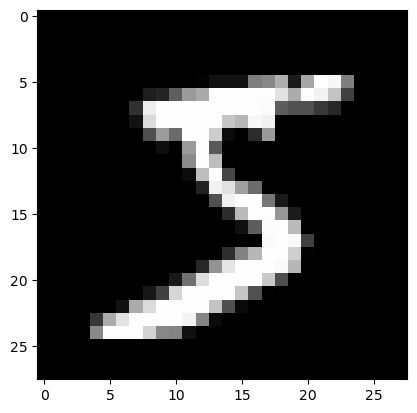

In [33]:
from matplotlib import pyplot
import numpy as np

pyplot.imshow(x_train[0].reshape((28, 28)), cmap="gray")
print(x_train.shape)

* PyTorch는 NumPy 배열 보다는 torch.tensor 를 사용하므로, 우리는 데이터를 변환해야 함.

In [34]:
import torch

x_train, y_train, x_valid, y_valid = map(
    torch.tensor, (x_train, y_train, x_valid, y_valid)
)
n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


### Neural net from scratch (without torch.nn)
* PyTorch 텐서 연산만으로 첫 모델을 만들어보기.

* PyTorch는 랜덤 또는 0으로만 이루어진 텐서를 생성하는 메소드를 제공하고, 우리는 간단한 선형 모델의 가중치(weights)와 절편(bias)을 생성하기 위해서 이것을 사용할 것.
* 이들은 일반적인 텐서에 매우 특별한 한가지가 추가된 것.
* 우리는 PyTorch에게 이들이 기울기(gradient)가 필요하다고 알려줌.
* 이를 통해 PyTorch는 텐서에 행해지는 모든 연산을 기록하게 하고, 따라서 자동적으로 역전파(back-propagation) 동안에 기울기를 계산할 수 있음!


* 가중치에 대해서는 requires_grad 를 초기화(initialization) **다음에** 설정함.
* 왜냐하면 우리는 해당 단계가 기울기에 포함되는 것을 원치 않기 때문임.
* (PyTorch에서 _ 다음에 오는 메소드 이름은 연산이 인플레이스(in-place)로 수행되는 것을 의미함.

* 참고
    + Xavier intialisation 기법을 이용하여 가중치를 초기화함.
    + $ \frac{1}{sqrt(n)} $ 을 곱해서 초기화.

In [35]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

* PyTorch의 기울기를 자동으로 계산해주는 기능 덕분에, Python 표준 함수 (또는 호출 가능한 객체)를 모델로 사용할 수 있음!
* 그러므로 간단한 선형 모델을 만들기 위해서 단순한 행렬 곱셈과 브로드캐스트(broadcast) 덧셈을 사용하여 보겠음.
* 또한, 우리는 활성화 함수(activation function)가 필요하므로, log_softmax 를 구현하고 사용할 것.
* PyTorch에서 많은 사전 구현된 손실 함수(loss function), 활성화 함수들이 제공되지만, 일반적인 python 을 사용하여 자신만의 함수를 쉽게 작성할 수 있음을 기억.
* PyTorch는 심지어 여러분의 함수를 위해서 빠른 GPU 또는 벡터화된 CPU 코드를 만들어줄 것.

In [36]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

* 위에서, @ 기호는 행렬 곱셈(matrix multiplication) 연산을 나타냄.
* 우리는 하나의 배치(batch) 데이터 (이 경우에는 64개의 이미지들)에 대하여 함수를 호출할 것.
* 이것은 하나의 포워드 전달(forward pass)임.
* 이 단계에서 우리는 무작위(random) 가중치로 시작했기 때문에 우리의 예측이 무작위 예측보다 전혀 나은 점이 없을 것.

In [37]:
bs = 64 # 배치 크기

xb = x_train[0:bs] # x로부터 미니배치(mini-batch) 추출
preds = model(xb) # 예측
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.1918, -2.7570, -2.5573, -2.3342, -1.9939, -2.2579, -2.4773, -2.5542,
        -2.3379, -1.8878], grad_fn=<SelectBackward0>) torch.Size([64, 10])


*  preds 텐서(tensor)는 텐서 값 외에도, 또한 기울기 함수(gradient function)을 담고 있음.
*  나중에 이것을 역전파(backpropagation)을 위해 사용할 것임.
*  이제 손실함수(loss function)로 사용하기 위한 음의 로그 우도(negative log-likelihood)를 구현함.

In [38]:
def nll(input, target):
    return -input[range(target.shape[0]), target].mean()

loss_func = nll

* 우리의 무작위 모델에 대한 손실을 점검해봄.
* 나중에 역전파 이후에 개선이 있는지 확인할 수 있음.

In [39]:
yb = y_train[0:bs]
print(loss_func(preds, yb))

tensor(2.3151, grad_fn=<NegBackward0>)


* 또한, 우리 모델의 정확도(accuracy)를 계산하기 위한 함수를 구현해봄.
* 매 예측마다, 만약 가장 큰 값의 인덱스가 목표값(target value)과 동일하다면, 그 예측은 올바른 것.

In [40]:
def accuracy(out, yb):
    preds = torch.argmax(out, dim=1)
    return (preds == yb).float().mean()

* 우리의 무작위 모델의 정확도를 점검해보기.
* 그럼으로써 손실이 개선됨에 따라서 정확도가 개선되는지 확인할 수 있음.

In [41]:
print(accuracy(preds, yb))

tensor(0.0781)


* 이제 우리는 훈련 루프(training loop)를 실행할 수 있음.
* 매 반복마다, 다음을 수행할 것임.
    + 데이터의 미니배치를 선택 (bs 크기)
    + 모델을 이용하여 예측 수행
    + 손실 계산
    + loss.backward() 를 이용하여 모델의 기울기 업데이터, 이 경우에는, weights 와 bias.

* 이제 이 기울기들을 이용하여 가중치와 절편을 업데이트 함.
* 이것을 torch.no_grad() 컨텍스트 매니저(context manager) 내에서 실행함.
* 왜냐하면 이러한 실행이 다음 기울기의 계산에 기록되지 않기를 원하기 때문임.

* 그러고나서 기울기를 0으로 설정함.
* 그럼으로써 다음 루프(loop)에 준비하게 됨.
* 그렇지 않으면, 기울기들은 일어난 모든 연산의 누적 집계를 기록하게 되어버림.
* (즉, loss.backward()가 이미 저장된 것을 대체하기보단, 기존 값에 기울기를 더하게 됨.)

* PyTorch 코드에 대하여 표준 python 디버거(debugger)를 사용할 수 있으므로, 매 단계마다 다양한 변수 값을 점검할 수 있음.
* 아래에서 set_trace()를 주석 해제하여 사용해보기.

In [42]:
from IPython.core.debugger import set_trace

lr = 0.5  # 학습률(learning rate)
epochs = 2  # 훈련에 사용할 에폭(epoch) 수

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        #         set_trace()
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()

* 제일 간단한 신경망(neural network)의 모든 것을 밑바닥부터 생성하고 훈련함.
* (이번에는 은닉층(hidden layer)이 없기 때문에, 로지스틱 회귀(logistic regression)임.)

* 이제 손실과 정확도를 이전 값들과 비교하면서 확인해보기.
* 우리는 손실은 감소하고, 정확도가 증가하기를 기대함.

In [43]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0829, grad_fn=<NegBackward0>) tensor(1.)


### Using torch.nn.functional
* 이제 우리는 코드를 리팩토링(refactoring) 하겠음.
* 그럼으로써 이전과 동일하지만, PyTorch의 nn 클래스의 장점을 활용하여 더 간결하고 유연하게 만들 것.
* 지금부터 매 단계에서, 우리는 코드를 더 짧고, 이해하기 쉽고, 유연하게 만들어야 함.

* 처음이면서 우리의 코드를 짧게 만들기 가장 쉬운 단계는 직접 작성한 활성화, 손실 함수를 torch.nn.functional 의 함수로 대체하는 것.
* (관례에 따라, 일반적으로 F 네임스페이스(namespace)를 통해 임포트(import)함.)
* 이 모듈에는 torch.nn 라이브러리의 모든 함수가 포함되어 있음.
* (라이브러리의 다른 부분에는 클래스가 포함되어 있음.)
* 다양한 손실 및 활성화 함수 뿐만 아니라, 풀링(pooling) 함수와 같이 신경망을 만드는데 편리한 몇 가지 함수도 여기에서 찾을 수 있음.
* (컨볼루션(convolution) 연산, 선형(linear) 레이어, 등을 수행하는 함수도 있지만, 앞으로 보시겠지만 일반적으로 라이브러리의 다른 부분을 사용하여 더 잘 처리 할 수 있음.)

* 만약 여러분들이 음의 로그 우도 손실과 로그 소프트맥스 (log softmax) 활성화 함수를 사용하는 경우, PyTorch는 이 둘을 결합하는 단일 함수인 F.cross_entropy 를 제공함.
* 따라서 모델에서 활성화 함수를 제거할 수도 있음.

In [44]:
import torch.nn.functional as F

loss_func = F.cross_entropy

def model(xb):
    return xb @ weights + bias

* 더이상 model 함수에서 log_softmax 를 호출하지 않고 있음.
* 손실과 정확도가 이전과 동일한지 확인해보기.

In [45]:
print(loss_func(model(xb), yb), accuracy(model(xb), yb))

tensor(0.0829, grad_fn=<NllLossBackward0>) tensor(1.)


### Refactor using nn.Module
* 다음으로, 더 명확하고 간결한 훈련 루프를 위해 nn.Module 및 nn.Parameter 를 사용함.
* 우리는 nn.Module (자체가 클래스이고 상태를 추적할 수 있는) 하위 클래스(subclass)를 만듦.
* 이 경우에는, 포워드(forward) 단계에 대한 가중치, 절편, 그리고 메소드(method) 등을 유지하는 클래스를 만들고자 함.
* nn.Module 은 우리가 사용할 몇 가지 속성(attribute)과 메소드를 (.parameters() 와 .zero_grad()) 같은 가지고 있음.

* 참고
    + nn.Module (대문자 M) 은 PyTorch 의 특정 개념이고, 우리는 이 클래스를 많이 사용할 것.
    + nn.Module 를 Python 의 코드를 임포트하기 위한 코드 파일인 module (소문자 m) 의 개념과 헷갈리지 않기.

In [46]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784, 10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self, xb):
        return xb @ self.weights + self.bias

* 함수를 사용하는 대신에 이제는 오브젝트(object) 를 사용하기 때문에, 먼저 모델을 인스턴스화(instantiate) 해야 함.

In [51]:
model = Mnist_Logistic()

* 이제 우리는 이전과 동일한 방식으로 손실을 계산할 수 있음.
* 여기서 nn.Module 오브젝트들은 마치 함수처럼 사용됨. (즉, 이들은 호출가능함.)
* 그러나 배후에서 PyTorch 는 우리의 forward 메소드를 자동으로 호출함.

In [52]:
print(loss_func(model(xb), yb))

tensor(2.4008, grad_fn=<NllLossBackward0>)


* 이전에는 훈련 루프를 위해 이름 별로 각 매개변수(parameter)의 값을 업데이트하고 다음과 같이 각 매개 변수에 대한 기울기들을 개별적으로 수동으로 0으로 제거해야 했음.

In [49]:
with torch.no_grad():
    weights -= weights.grad * lr
    bias -= bias.grad * lr
    weights.grad.zero_()
    bias.grad.zero_()

* 이제 우리는 model.parameters() 및 model.zero_grad() (모두 nn.Module 에 대해 PyTorch에 의해 정의됨)를 활용하여 이러한 단계를 더 간결하게 만들고, 특히 더 복잡한 모델에 대해서 일부 매개변수를 잊어버리는 오류를 덜 발생시킬 수 있음.

In [53]:
with torch.no_grad():
    for p in model.parameters():
        p -= p.grad * lr
    model.zero_grad()

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

* 이제 이것을 나중에 다시 실행할 수 있도록 fit 함수로 작은 훈련 루프를 감쌀 것임.

In [54]:
def fit():
    for epoch in range(epochs):
        for i in range((n - 1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            pred = model(xb)
            loss = loss_func(pred, yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()

fit()

* 손실이 줄어들었는지 다시 한번 확인해보기.

In [55]:
print(loss_func(model(xb), yb))

tensor(0.0802, grad_fn=<NllLossBackward0>)


### Refactor using nn.Linear
* 계속해서 코드를 리팩토링 함.
* self.weights 및 self.bias 를 수동으로 정의 및 초기화하고, xb @ self.weights + self.bias 를 계산하는 대신에, 위의 모든 것을 해줄 PyTorch 클래스인 nn.Linear 를 선형 레이어로 사용함.
* PyTorch 에는 다양한 유형의 코드를 크게 단순화 할 수 있는 미리 정의된 레이어가 있고 이는 또한 종종 기존 코드보다 속도를 빠르게 함.

In [56]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10)

    def forward(self, xb):
        return self.lin(xb)

* 이전과 같은 방식으로 모델을 인스턴스화하고 손실을 계산함.

In [57]:
model = Mnist_Logistic()
print(loss_func(model(xb), yb))

tensor(2.2969, grad_fn=<NllLossBackward0>)


* 우리는 여전히 이전과 동일한 fit 메소드를 사용할 수 있음

In [58]:
fit()

print(loss_func(model(xb), yb))

tensor(0.0820, grad_fn=<NllLossBackward0>)


### Refactor using torch.optim
* PyTorch에는 다양한 최적화(optimization) 알고리즘을 가진 패키지인 torch.optim 도 있음.
* 각 매개변수를 수동으로 업데이트 하는 대신, 옵티마이저(optimizer)의 step 메소드를 사용하여 업데이트를 진행할 수 있음.

* 이렇게 하면 이전에 수동으로 코딩한 최적화 단계를 대체할 수 있음.

In [ ]:
with torch.no_grad():
    for p in model.parameters(): p-= p.grad * lr
    model.zero_grad()

* 대신에 이렇게 말이죠.

In [ ]:
opt.step()
opt.zero_grad()

* optim.zero_grad() 는 기울기를 0으로 재설정 해줌.
* 다음 미니 배치에 대한 기울기를 계산하기 전에 호출해야 함.

In [59]:
from torch import optim

* 나중에 다시 사용할 수 있도록 모델과 옵티마이져를 만드는 작은 함수를 정의함.

In [60]:
def get_model():
    model = Mnist_Logistic()
    return model, optim.SGD(model.parameters(), lr=lr)

model, opt = get_model()
print(loss_func(model(xb), yb))

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(2.2889, grad_fn=<NllLossBackward0>)
tensor(0.0820, grad_fn=<NllLossBackward0>)


### Refactor using Dataset
* PyTorch 에는 추상 Dataset 클래스가 있음.
* Dataset 은 \_len\_ 함수 (Python의 표준 len 함수에 의해 호출됨) 및 \_getitem\_ 함수를 가진 어떤 것이라도 될 수 있으며, 이 함수들을 인덱싱(indexing) 하기 위한 방법으로 사용함.
* 이 튜토리얼은 Dataset)의 하위 클래스로써, 사용자 지정 FacialLandmarkDataset 클래스를 만드는 좋은 예를 제시함.

* PyTorch 의 TensorDataset 은 텐서를 감싸는 (wrapping) Dataset 임.
* 길이와 인덱싱 방식을 정의함으로써 텐서의 첫 번째 차원을 따라 반복, 인덱싱 및 슬라이스(slice) 하는 방법도 제공함.
* 이렇게하면 훈련 할 때 동일한 라인에서 독립(independent) 변수와 종속(dependent) 변수에 쉽게 액세스 할 수 있음.

In [61]:
from torch.utils.data import TensorDataset

* x_train 및 y_train 모두 하나의 TensorDataset 에 합쳐질 수 있음.
* 따라서 반복시키고 슬라이스 하기 편리함.

In [62]:
train_ds = TensorDataset(x_train, y_train)

* 이전에는 x 및 y 값의 미니 배치를 별도로 반복해야 했음.

In [ ]:
xb = x_train[start_i:end_i]
yb = y_train[start_i:end_i]

* 이제 이 두 단계를 함께 수행할 수 있음.

In [ ]:
xb, yb = train_ds[i*bs : i*bs+bs]

In [63]:
model, opt = get_model()

for epoch in range(epochs):
    for i in range((n - 1) // bs + 1):
        xb, yb = train_ds[i * bs: i * bs + bs]
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0819, grad_fn=<NllLossBackward0>)


### DataLoader 를 사용하여 리팩토링하기
* PyTorch 의 DataLoader 는 배치 관리를 담당함.
* 모든 Dataset 으로부터 DataLoader를 생성할 수 있음.
* DataLoader 는 배치들에 대해서 반복하기 쉽게 만들어줌.
* train_ds[i * bs : i * bs + bs] 를 사용하는 대신, Dataloader 는 매 미니매치를 자동적으로 제공함.

In [64]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

* 이전에는 루프가 다음과 같이 배치 (xb, yb) 를 반복함.

In [65]:
for i in range((n - 1) // bs + 1):
    xb, yb = train_ds[i * bs : i * bs + bs]
    pred = model(xb)

* 이제 (xb, yb)가 DataLoader 에서 자동으로 로드되므로 루프가 훨씬 깨끗해짐.

In [66]:
for xb, yb in train_dl:
    pred = model(xb)

In [67]:
model, opt = get_model()

for epoch in range(epochs):
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb), yb))

tensor(0.0823, grad_fn=<NllLossBackward0>)


* PyTorch 의 nn.Module, nn.Parameter, Dataset 및 DataLoader 덕분에 이제 훈련 루프가 훨씬 더 작아지고 이해하기 쉬워짐.
* 이제 실제로 효과적인 모델을 만드는 데 필요한 기본 기능을 추가해보겠음.

### Add validation
* 섹션 1에서, 우리는 훈련 데이터에 사용하기 위해 합리적인 훈련 루프를 설정하려고 했음.
* 실전에서, 과적합(overfitting)을 확인하기 위해서 **항상** 검증 데이터셋(validation set)이 있어야 함.

* 훈련 데이터를 섞는(shuffling) 것은 배치와 과적합 사이의 상관관계를 방지하기 위해 중요함.
* 반면에, 검증 손실(validation loss)은 검증 데이터셋을 섞든 안섞든 동일함.
* 데이터를 섞는 것은 추가 시간이 걸리므로, 검증 데이터를 섞는 것은 의미가 없음.

* 검증 데이터셋에 대한 배치 크기는 학습 데이터셋 배치 크기의 2배를 사용할 것.
* 이는 검증 데이터셋에 대해서는 역전파(backpropagation)가 필요하지 않으므로 메모리를 덜 사용하기 때문임.
* (기울기를 저장할 필요가 없음).
* 더 큰 배치 크기를 사용하여 손실을 더 빨리 계산하기 위해 이렇게 함.

In [68]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs * 2)

* 각 에폭이 끝날 때 검증 손실을 계산하고 프린트 할 것.

* 훈련 전에 항상 model.train() 을 호출하고, 추론(inference) 전에 model.eval() 을 호출함.
* 이는 nn.BatchNorm2d 및 nn.Dropout 과 같은 레이어에서 이러한 다른 단계(훈련, 추론) 에 대한 적절한 동작이 일어나게 하기 위함임.

In [69]:
model, opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb, yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred, yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb), yb) for xb, yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))

0 tensor(0.4002)
1 tensor(0.2914)


### Create fit() and get_data()
* 이제 우리는 우리만의 작은 리팩토링을 수행할 것.
* 훈련 데이터셋과 검증 데이터셋 모두에 대한 손실을 계산하는 유사한 프로세스를 두 번 거치므로, 이를 하나의 배치에 대한 손실을 계산하는 자체 함수 loss_batch 로 만들어보겠음.

* 훈련 데이터셋에 대한 옵티마이저를 전달하고 이를 사용하여 역전파를 수행함.
* 검증 데이터셋의 경우 옵티마이저를 전달하지 않으므로 메소드가 역전파를 수행하지 않음.

In [70]:
def loss_batch(model, loss_func, xb, yb, opt=None):
    loss = loss_func(model(xb), yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

* fit 은 모델을 훈련하고 각 에폭에 대한 훈련 및 검증 손실을 계산하는 작업을 수행함.

In [71]:
import numpy as np

def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model, loss_func, xb, yb) for xb, yb in valid_dl]
            )
        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)

        print(epoch, val_loss)

* get_data 는 학습 및 검증 데이터셋에 대한 dataloader 를 출력함.

In [74]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

* 이제 dataloader 를 가져오고 모델을 훈련하는 전체 프로세스를 3줄의 코드로 실행할 수 있음.

In [76]:
train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model, opt = get_model()
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3162924583673477
1 0.30836911851763726


* 이러한 기본 3줄의 코드를 사용하여 다양한 모델을 훈련할 수 있음.
* 컨볼루션 신경망 (CNN) 을 훈련하는 데 사용할 수 있는지 살펴 보겠음.

### Switch to CNN
* 이제 3개의 컨볼루션 레이어로 신경망을 구축할 것.
* 이전 섹션의 어떤 함수도 모델의 형식에 대해 가정하지 않기 때문에, 별도의 수정없이 CNN을 학습하는 데 사용할 수 있음.

* PyTorch의 사전정의된 Conv2d 클래스를 컨볼루션 레이어로 사용함.
* 3개의 컨볼루션 레이어로 CNN을 정의함.
* 각 컨볼루션 뒤에는 ReLU가 있음.
* 마지막으로 평균 풀링(average pooling)을 수행함.
* (view 는 PyTorch의 NumPy reshape 버전임.)

In [78]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1)

    def forward(self, xb):
        xb = xb.view(-1, 1, 28, 28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb, 4)
        return xb.view(-1, xb.size(1))

lr = 0.1

* 모멘텀(Momentum) 은 이전 업데이트도 고려하고 일반적으로 더 빠른 훈련으로 이어지는 확률적 경사하강법(stochastic gradient descent) 의 변형임.

In [79]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3595779992580414
1 0.248404425740242


### Using nn.Sequential
* torch.nn 에는 코드를 간단히 사용할 수 있는 또 다른 편리한 클래스인 Sequential 이 있음.
* Sequential 객체는 그 안에 포함된 각 모듈을 순차적으로 실행함.
* 이것은 우리의 신경망을 작성하는 더 간단한 방법임.

* 이를 활용하려면 주어진 함수에서 **사용자정의 레이어(custom layer)** 를 쉽게 정의할 수 있어야 함.
* 예를 들어, PyTorch에는 view레이어가 없으므로 우리의 신경망용으로 만들어야 함.
* Lambda 는 Sequential 로 신경망을 정의할 때 사용할 수 있는 레이어를 생성할 것임.

In [80]:
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)

def preprocess(x):
    return x.view(-1, 1, 28, 28)

* Sequential 로 생성된 모듈은 간단하게 아래와 같음.

In [81]:
model = nn.Sequential(
    Lambda(preprocess),
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AvgPool2d(4),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.3955372458934784
1 0.3087213083267212


### Wrapping DataLoader

* 현재 CNN은 상당히 간결하지만, MNIST에서만 작동함.
* 이유는
    + 입력이 28x28의 긴 벡터라고 가정함.
    + 최종적으로 CNN 그리드 크기는 4x4라고 가정함.
    + (이것은 우리가 사용한 평균 풀링 커널 크기 때문임.)

* 이 두 가지 가정을 제거하여 모델이 모든 2d 단일 채널(channel) 이미지에서 작동하도록 하겠음.
* 먼저 초기 Lambda 레이어를 제거하고 데이터 전처리를 제너레이터(generator)로 이동시킬 수 있음.

In [82]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28), y


class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

* 다음으로, nn.AvgPool2d 를 nn.AdaptiveAvgPool2d 로 대체하여 우리가 가진 입력 텐서가 아니라 원하는 출력 텐서의 크기를 정의할 수 있음.
* 결과적으로 모델은 모든 크기의 입력과 함께 작동함.

In [83]:
model = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.Conv2d(16, 10, kernel_size=3, stride=2, padding=1),
    nn.ReLU(),
    nn.AdaptiveAvgPool2d(1),
    Lambda(lambda x: x.view(x.size(0), -1)),
)

opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

* 한번 실행해보겠음.

In [84]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.5658090400695801
1 0.4720685434818268


### Using your GPU
* 만약 운이 좋아서 CUDA 지원 GPU (대부분의 클라우드 제공 업체에서 돈을 내거나 Colab 을 사용 가능.) 를 사용할 수 있다면, 코드 실행 속도를 높일 수 있음.
* 먼저 GPU가 PyTorch에서 작동하는지 확인함.

In [85]:
print(torch.cuda.is_available())

True


* 그리고 이에 대한 디바이스 오브젝트를 생성함.

In [86]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

* GPU로 배치를 옮기도록 preprocess 를 업데이트

In [88]:
def preprocess(x, y):
    return x.view(-1, 1, 28, 28).to(dev), y.to(dev)


train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
valid_dl = WrappedDataLoader(valid_dl, preprocess)

* 마지막으로 모델을 GPU로 이동시킬 수 있음.

In [89]:
model.to(dev)
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

* 이제 더 빨리 실행됨.

In [90]:
fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.42758629879951476
1 0.4136501205921173


### Closing thoughts
* 이제 PyTorch를 사용하여 다양한 유형의 모델을 학습하는 데 사용할 수 있는 일반 데이터 파이프 라인과 훈련 루프가 있음.

* 물론 데이터 증강(data augmentation), 초매개변수 조정(hyperparameter tuning), 훈련과정 모니터링(monitoring training), 전이 학습(transfer learning) 등과 같이 추가하고 싶은 항목들이 많이 있을 것.
* 이러한 기능들은 이 튜토리얼에 표시된 것과 동일한 설계 접근 방식을 사용하여 개발된 fastai 라이브러리에서 사용할 수 있으며, 모델을 더욱 발전시키려는 실무자에게 자연스러운 다음 단계를 제공함.

* 이 튜토리얼의 시작 부분에서 torch.nn, torch.optim, Dataset, 그리고 DataLoader 의 각 예제를 통해 설명하겠다고 이야기함.
* 위의 내용을 요약해보자면 다음과 같음.
    + torch.nn :
        - Module : 함수처럼 동작하지만, 또한 상태(state) (예를 들어, 신경망의 레이어 가중치)를 포함할 수 있는 호출 가능한 오브젝트를 생성함.
        - 이는 포함된 Parameter (들)가 어떤 것인지 알고, 모든 기울기를 0으로 설정하고 가중치 업데이트 등을 위해 반복할 수 있음.
        - Parameter : Module 에 역전파 동안 업데이트가 필요한 가중치가 있음을 알려주는 텐서용 래퍼임.
        - requires_grad 속성이 설정된 텐서만 업데이트 됨.
        - functional : 활성화 함수, 손실 함수 등을 포함하는 모듈 (관례에 따라 일반적으로 F 네임스페이스로 임포트 됨.) 이고, 물론 컨볼루션 및 선형 레이어 등에 대해서 상태를 저장하지 않는(non-stateful)버전의 레이어를 포함함.
    + torch.optim : 역전파 단계에서 Parameter 의 가중치를 업데이트하는, SGD 와 같은 옵티마이저를 포함함.
    + Dataset : TensorDataset 과 같이 PyTorch 와 함께 제공되는 클래스를 포함하여 \_\_len\_\_ 및 \_\_getitem\_\_ 이 있는 객체의 추상 인터페이스
    + DataLoader : 모든 종류의 Dataset 을 기반으로 데이터의 배치들을 출력하는 반복자(iterator)를 생성함.